In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def bs_euler(S0, K, r, sigma, T, gamma, N, M):
    """
    Euler-Maruyama method for option pricing
    """
    dt = T / N
    S = S0 * np.ones(M)
    
    for n in range(N):
        dW = np.sqrt(dt) * np.random.randn(M)
        S = S + r * S * dt + sigma * (S ** gamma) * dW
    
    payoff = np.maximum(S - K, 0)
    return np.exp(-r * T) * np.mean(payoff)

In [2]:
def bsexact(sigma, r, E, T, s):
    d1 = (np.log(s/E) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    F = s * norm.cdf(d1) - np.exp(-r*T)*E*norm.cdf(d2)
    return F

In [ ]:
S0 = 14
K = 15
r = 0.1
sigma = 0.25
T = 0.5
gamma = 1
N = 500
M = 100000

V_mc = bs_euler(S0, K, r, sigma, T, gamma, N, M)
V_true = bsexact(sigma, r, K, T, S0)

print(f'Monte Carlo solution: {V_mc:.4f}')
print(f'Exact solution: {V_true:.4f}')
print(f'Error: {abs(V_mc - V_true):.4f}')

Monte Carlo solution: 0.8718
Exact solution: 0.8670
Error: 0.0048


In [4]:
def bs_euler_anti(S0, K, r, sigma, T, gamma, N, M):
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(N, M)
    
    S = S0 * np.ones(M)
    S_anti = S0 * np.ones(M)
    
    for n in range(N):
        S = S + r * S * dt + sigma * (S ** gamma) * dW[n, :]
        S_anti = S_anti + r * S_anti * dt + sigma * (S_anti ** gamma) * (-dW[n, :])
    
    payoff = np.maximum(S - K, 0)
    payoff_anti = np.maximum(S_anti - K, 0)
    
    return np.exp(-r * T) * np.mean(0.5 * (payoff + payoff_anti))

In [5]:
S0 = 14
K = 15
r = 0.1
sigma = 0.25
T = 0.5
gamma = 1
N = 500
M = 100000

V_mc = bs_euler(S0, K, r, sigma, T, gamma, N, M)
V_mc_anti = bs_euler_anti(S0, K, r, sigma, T, gamma, N, M)

print(f'Standard MC: {V_mc:.4f}')
print(f'Antithetic MC: {V_mc_anti:.4f}')

Standard MC: 0.8695
Antithetic MC: 0.8685


In [6]:
def milstein(S0, K, r, sigma, T, gamma, N, M):
    dt = T / N
    S = S0 * np.ones(M)
    
    for n in range(N):
        dW = np.sqrt(dt) * np.random.randn(M)
        S = S + r * S * dt + sigma * (S ** gamma) * dW + \
            0.5 * sigma**2 * gamma * S**(2*gamma-1) * ((dW**2) - dt)
    
    payoff = np.maximum(S - K, 0)
    return np.exp(-r * T) * np.mean(payoff)

In [7]:
S0 = 14
K = 15
r = 0.1
sigma = 0.25
T = 0.5
gamma = 1
N = 500
M = 100000

V_mc = bs_euler(S0, K, r, sigma, T, gamma, N, M)
V_milstein = milstein(S0, K, r, sigma, T, gamma, N, M)

print(f'Euler MC: {V_mc:.4f}')
print(f'Milstein: {V_milstein:.4f}')

Euler MC: 0.8688
Milstein: 0.8720


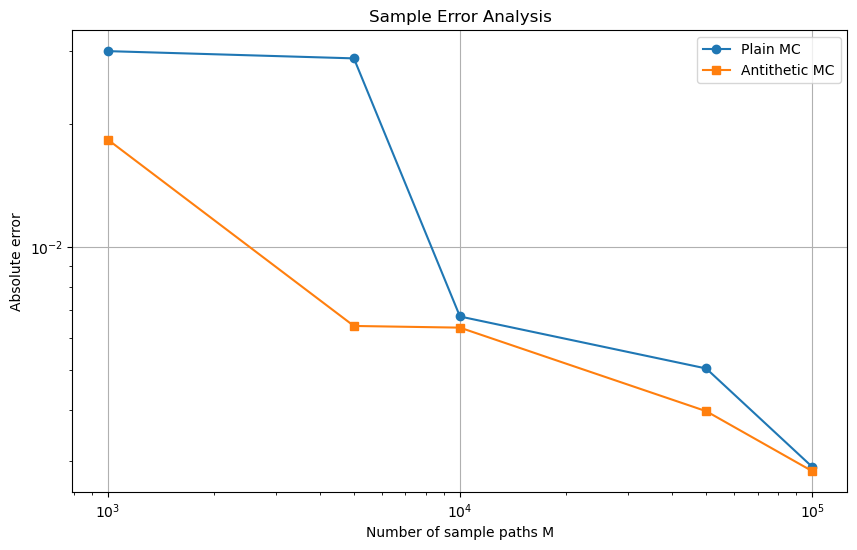

In [11]:
S0 = 14
K = 15
r = 0.1
sigma = 0.25
T = 0.5
N = 500
gamma = 1
M_vals = [1000, 5000, 10000, 50000, 100000]
err_plain = np.zeros(len(M_vals))
err_anti = np.zeros(len(M_vals))
V_true = 0.867  

for i, M in enumerate(M_vals):
    V_plain = bs_euler(S0, K, r, sigma, T, gamma, N, M)
    V_anti = bs_euler_anti(S0, K, r, sigma, T, gamma, N, M)
    err_plain[i] = abs(V_plain - V_true)
    err_anti[i] = abs(V_anti - V_true)

plt.figure(figsize=(10, 6))
plt.plot(M_vals, err_plain, '-o', label='Plain MC')
plt.plot(M_vals, err_anti, '-s', label='Antithetic MC')
plt.xlabel('Number of sample paths M')
plt.ylabel('Absolute error')
plt.title('Sample Error Analysis')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.show()

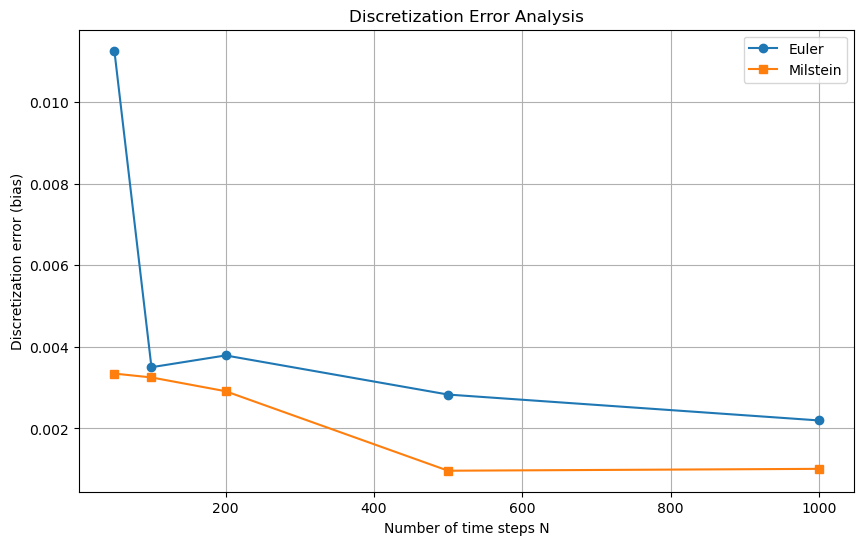

In [12]:
S0 = 14
K = 15
r = 0.1
sigma = 0.25
T = 0.5
M = 100000
gamma = 1
N_vals = [50, 100, 200, 500, 1000]
bias_euler = np.zeros(len(N_vals))
bias_milstein = np.zeros(len(N_vals))
V_true = 0.867  

for i, N in enumerate(N_vals):
    V_e = bs_euler(S0, K, r, sigma, T, gamma, N, M)
    V_m = milstein(S0, K, r, sigma, T, gamma, N, M)
    bias_euler[i] = abs(V_e - V_true)
    bias_milstein[i] = abs(V_m - V_true)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(N_vals, bias_euler, '-o', label='Euler')
plt.plot(N_vals, bias_milstein, '-s', label='Milstein')
plt.xlabel('Number of time steps N')
plt.ylabel('Discretization error (bias)')
plt.title('Discretization Error Analysis')
plt.legend()
plt.grid(True)
plt.show()

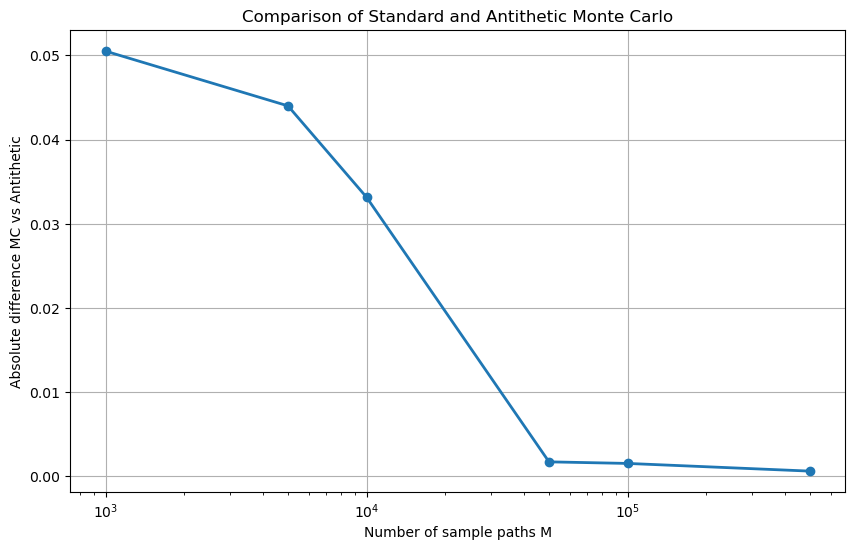

In [21]:
S0 = 14
K = 15
r = 0.1
sigma = 0.25
T = 0.5
N = 500
M_vals = [1000, 5000, 10000, 50000, 100000, 500000]
err = np.zeros(len(M_vals))

for i, M in enumerate(M_vals):
    V1 = bs_euler(S0, K, r, sigma, T, 1, N, M)
    V2 = bs_euler_anti(S0, K, r, sigma, T, 1, N, M)
    err[i] = abs(V1 - V2)

plt.figure(figsize=(10, 6))
plt.plot(M_vals, err, '-o', linewidth=2)
plt.xlabel('Number of sample paths M')
plt.ylabel('Absolute difference MC vs Antithetic')
plt.title('Comparison of Standard and Antithetic Monte Carlo')
plt.grid(True)
plt.xscale('log')
plt.show()

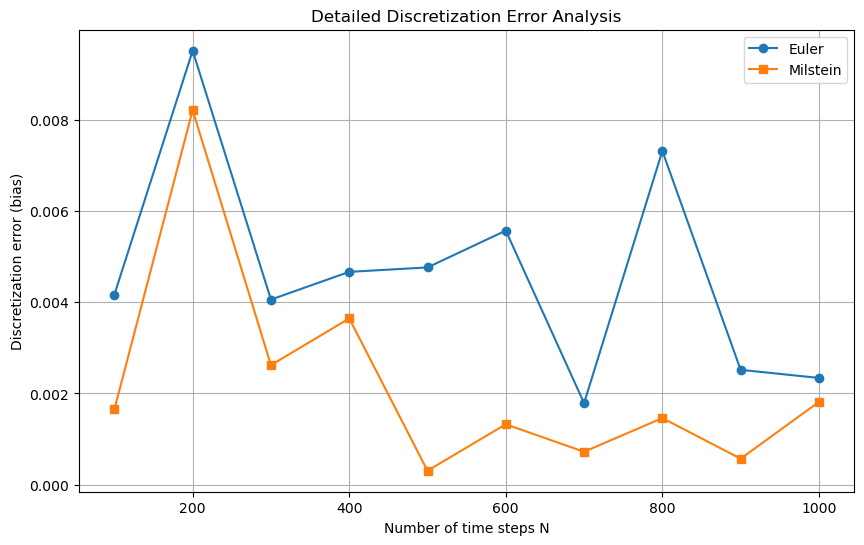

In [20]:
S0 = 14
K = 15
r = 0.1
sigma = 0.25
T = 0.5
M = 100000
gamma = 1
N_vals = range(100, 1001, 100)
V_true = 0.867 

bias_euler = np.zeros(len(N_vals))
bias_milstein = np.zeros(len(N_vals))

for i, N in enumerate(N_vals):
    V_e = bs_euler(S0, K, r, sigma, T, gamma, N, M)
    V_m = milstein(S0, K, r, sigma, T, gamma, N, M)
    bias_euler[i] = abs(V_e - V_true)
    bias_milstein[i] = abs(V_m - V_true)

plt.figure(figsize=(10, 6))
plt.plot(N_vals, bias_euler, '-o', label='Euler')
plt.plot(N_vals, bias_milstein, '-s', label='Milstein')
plt.xlabel('Number of time steps N')
plt.ylabel('Discretization error (bias)')
plt.title('Detailed Discretization Error Analysis')
plt.legend()
plt.grid(True)
plt.show()

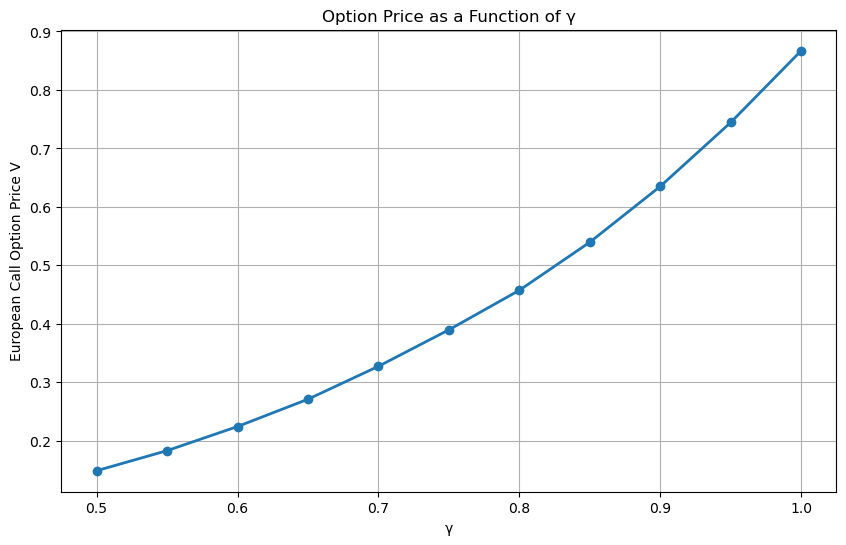

In [19]:
S0 = 14
K = 15
r = 0.1
sigma = 0.25
T = 0.5
N = 500
M = 100000

gamma_vals = np.arange(0.5, 1.05, 0.05)
V_vals = np.zeros(len(gamma_vals))

for i, gamma in enumerate(gamma_vals):
    V_vals[i] = bs_euler_anti(S0, K, r, sigma, T, gamma, N, M)

plt.figure(figsize=(10, 6))
plt.plot(gamma_vals, V_vals, '-o', linewidth=2, markersize=6)
plt.xlabel('γ')
plt.ylabel('European Call Option Price V')
plt.title('Option Price as a Function of γ')
plt.grid(True)
plt.show()